In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.graph_objects as go

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv("https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv", index_col=0, parse_dates=True)
df.sort_values(by='Date',ascending=True, inplace=True)
df.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


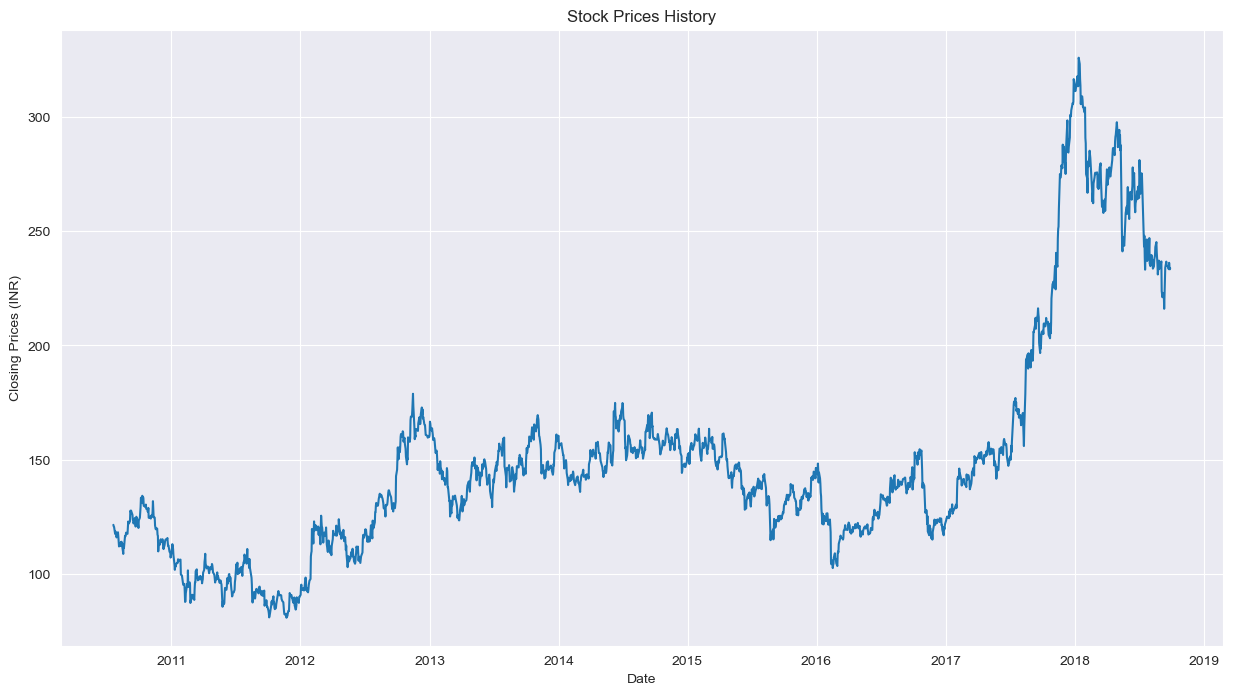

In [22]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Prices (INR)')
plt.show()

In [11]:
# Correlation of Closing Prices
correlation = df.corr()
print(correlation["Close"].sort_values(ascending=False))

Close                   1.000000
Last                    0.999961
High                    0.999194
Low                     0.999119
Open                    0.997840
Turnover (Lacs)         0.624213
Total Trade Quantity    0.398911
Name: Close, dtype: float64


In [12]:
# Create a new dataframe with only the 'Close' column 
close_prices = df['Close'].values

# Extracting only 80% of data for training
training_data_len = math.ceil(len(close_prices)* 0.8)

# Create the scaled training data set
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_prices.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

In [13]:
# Preparing train set
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    

# Convert the data to a numpy array and reshaping into 3d array  
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
# Preparing test set
# Extracting the remaining 20% data
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = close_prices[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array and reshaping into 3d array  
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
# Defining Sequential model 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 33,201
Trainable params: 33,201
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Training LSTM model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=100)

Epoch 1/100
49/49 [==============================] - 3s 26ms/step - loss: 0.0031
Epoch 2/100
49/49 [==============================] - 1s 22ms/step - loss: 6.3532e-04
Epoch 3/100
49/49 [==============================] - 1s 21ms/step - loss: 5.6355e-04
Epoch 4/100
49/49 [==============================] - 1s 22ms/step - loss: 5.1381e-04
Epoch 5/100
49/49 [==============================] - 2s 43ms/step - loss: 4.4609e-04
Epoch 6/100
49/49 [==============================] - 2s 47ms/step - loss: 4.4086e-04
Epoch 7/100
49/49 [==============================] - 2s 46ms/step - loss: 3.9011e-04
Epoch 8/100
49/49 [==============================] - 2s 47ms/step - loss: 3.8381e-04
Epoch 9/100
49/49 [==============================] - 2s 49ms/step - loss: 3.5741e-04
Epoch 10/100
49/49 [==============================] - 2s 47ms/step - loss: 3.2413e-04
Epoch 11/100
49/49 [==============================] - 2s 50ms/step - loss: 3.1838e-04
Epoch 12/100
49/49 [==============================] - 2s 48ms/step 

In [17]:
# Predicting the stock prices based on the test set.
predictions = model.predict(x_test)

# Performing inverse transform to denormalize the predicted stock
predictions = scaler.inverse_transform(predictions)

# Calculating the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

13/13 [==============================] - 1s 9ms/step


4.370406002260249

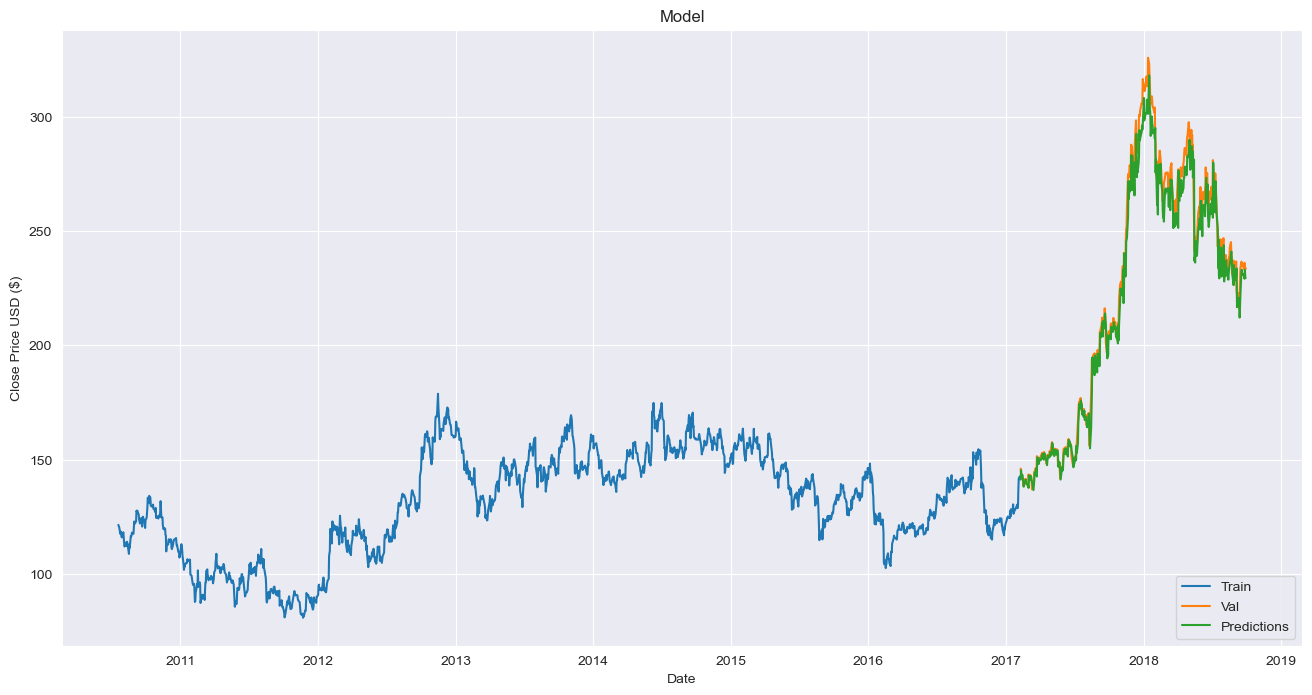

In [21]:
# Visualizing predicted and actual values
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [23]:
validation

,Close,Predictions
Date,,
2017-02-08,146.15,141.325867
2017-02-09,143.90,145.485962
2017-02-10,143.95,143.414566
2017-02-13,141.95,143.310532
2017-02-14,141.20,141.335861
...,...,...
2018-09-24,233.30,230.536942
2018-09-25,236.10,229.128815
2018-09-26,234.25,232.994705
